## Lab 8:  Clustering
Environmental justice (EJ) seeks to ensure that all communities, regardless of socioeconomic status or demographic background, have equal access to clean air, water, and, in the form of energy justice, access to renewable energy resources while minimizing exposure to environmental hazards. In this lab, we will apply clustering analysis to explore how U.S. counties group together based on renewable energy potential, demographic characteristics, and environmental risk factors.

The EEIP dataset was collated by the National Renewable Energy Lab (NREL) and contains a large set of features from multiple other databases including SLOPE (renewable energy potential) and EJSCREEN (environmental risk indicators).

Link to metadata: https://ucsb.box.com/s/x3olvh3rd8w5h7xz8jnm3v8g3t4ajjsg

First you will step through a guided clustering exploration of renewable energy production potential.  Then you will formulate a question of your own that brings in an environmental justice component.


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Load the EEIP dataset 
eeip_data = pd.read_csv("data/eeip.data.csv")

In [2]:
eeip_data.head()

,county_fips,county,state,county_pop,utilitypv_techpot_quint,utility_pv_technical_generation_potential_mwh,residentialpv_techpot_quint,residential_pv_technical_generation_potential_mwh,landbasedwind_techpot_quint,land_based_wind_technical_generation_potential_mwh,...,rmpprox_2_prop,rmpprox_3_prop,rmpprox_4_prop,rmpprox_5_prop,tsdf_indicator,tsdfprox_1_prop,tsdfprox_2_prop,tsdfprox_3_prop,tsdfprox_4_prop,tsdfprox_5_prop
0,1001,Autauga,AL,55200,3,3.585222e+07,4.0,122752.69,3,4374954.41,...,0.156250,0.031250,0.000000,0.0,0.0,0.343750,0.187500,0.281250,0.156250,0.03125
1,1003,Baldwin,AL,208107,5,1.257822e+08,5.0,483008.57,3,4368631.72,...,0.127660,0.031915,0.053191,0.0,0.0,0.521277,0.297872,0.159574,0.021277,0.00000
2,1005,Barbour,AL,25782,4,6.614827e+07,3.0,42823.79,3,5898864.51,...,0.173913,0.304348,0.130435,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.00000
3,1007,Bibb,AL,22527,2,1.926909e+07,2.0,37917.84,3,3986770.03,...,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.600000,0.066667,0.000000,0.00000
4,1009,Blount,AL,57645,2,2.261702e+07,4.0,122024.81,3,6117474.83,...,0.085714,0.057143,0.000000,0.0,0.0,0.714286,0.171429,0.114286,0.000000,0.00000


## Part I:
In this part, we will step through an analysis that examines how US counties cluster in their potential production of renewable energy.  

### Step 1: Exploratory Data Analysis

First we need to check for missing data and remove incomplete rows. Since clustering is a distance-based technique, we also need to ensure that the features used for clustering are scaled appropriately to prevent dominant features from skewing results.  For our first analysis, use the following variables from the SLOPE dataset related to energy production potential as your features: 
- `utility_pv_technical_generation_potential_mwh`
- `residential_pv_technical_generation_potential_mwh`
- `land_based_wind_technical_generation_potential_mwh`
- `commercial_pv_technical_generation_potential_mwh`

*Information on these variables is available on line 7 of the ColumnsExplained tab of the metadata*

Once you have removed incomplete rows and scaled, print the shape of your processed dataframe. 

In [3]:
# Check for and drop rows with missing data
eeip_clean = eeip_data[["county_fips", 
                        "county",
                        "state",
                        "lowincome_pop_5_prop",
                        "respiratoryhazardairtoxics_5_prop",
                        "utility_pv_technical_generation_potential_mwh",
                        "residential_pv_technical_generation_potential_mwh",
                        "land_based_wind_technical_generation_potential_mwh",
                        "commercial_pv_technical_generation_potential_mwh"]].dropna()

# Confirm rows with missing data have been dropped
print(eeip_clean.isna().sum())

county_fips                                           0
county                                                0
state                                                 0
lowincome_pop_5_prop                                  0
respiratoryhazardairtoxics_5_prop                     0
utility_pv_technical_generation_potential_mwh         0
residential_pv_technical_generation_potential_mwh     0
land_based_wind_technical_generation_potential_mwh    0
commercial_pv_technical_generation_potential_mwh      0
dtype: int64


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Scale data
eeip_scaled = scaler.fit_transform(eeip_clean[["utility_pv_technical_generation_potential_mwh",
                                               "residential_pv_technical_generation_potential_mwh",
                                               "land_based_wind_technical_generation_potential_mwh",
                                               "commercial_pv_technical_generation_potential_mwh"]])

# Convert back to a DataFrame
scaled_df = pd.DataFrame(eeip_scaled, columns=["utility_pv_technical_generation_potential_mwh",
                                                     "residential_pv_technical_generation_potential_mwh",
                                                     "land_based_wind_technical_generation_potential_mwh",
                                                     "commercial_pv_technical_generation_potential_mwh"]).reset_index(drop=True)

# Shape of processed dataframe
print(f"Shape of processed dataframe: {scaled_df.shape}")


Shape of processed dataframe: (3107, 4)


### Step 2: Hierarchical Clustering Analysis

Now that we have preprocessed our dataset and standardized the energy potential features, we will use hierarchical clustering to explore how counties group together based on their energy potential.

A dendrogram is a tree-like visualization that shows how clusters are merged step by step. By analyzing the dendrogram, we can decide the optimal number of clusters by looking at the distance between merges.

Use `linkage()` to perform the clustering.  Use 'ward' for the `method` parameter, a method which minimizes the variance within clusters, producing well-balanced groups. We will first visualize the **full dendrogram** using `dendrogram` before deciding on a truncation strategy.


Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram')

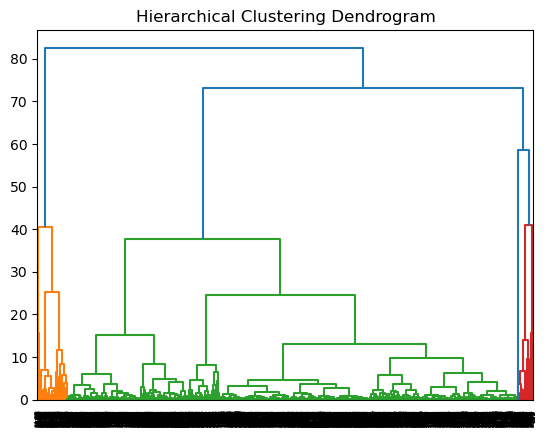

In [5]:
# Hierarchical clustering
eeip_linked = linkage(scaled_df, 'ward')

# Dendrogram for hierarchical clustering
dendrogram(eeip_linked)
plt.title("Hierarchical Clustering Dendrogram")


### Step 3: Set Up Cluster Interpretation

After determining the optimal number of clusters from the dendrogram, we now assign each county to a cluster using the extracted cluster labels.

To better understand the clustering results, we will:
- Define `num_clusters` as the ideal number of clusters based on the dendrogram created above
- Extract cluster assignment attribute from the hierarchical clustering using `fcluster()` with `criterion = "maxclust"`
- Create a new variable `Cluster` in your cleaned dataframe and assign cluster labels to it
- Compute and print the mean values of the original energy potential features for each cluster.

This summary will help us interpret how counties differ in energy potential across clusters and inform possible next steps for analysis.


In [6]:
# Set the number of clusters based on the dendrogram
num_clusters = 4

# Extract cluster assignments
cluster_labels = fcluster(Z=eeip_linked, t=num_clusters, criterion='maxclust') 

# Add a new column `Cluster` to the cleaned datframe
scaled_df['Cluster'] = cluster_labels

# Mean values of the energy potential features for each cluster
energy_means = scaled_df.groupby(['Cluster']).mean()
print(energy_means)

         utility_pv_technical_generation_potential_mwh  \
Cluster                                                  
1                                             2.831068   
2                                            -0.184742   
3                                            -0.076363   
4                                            -0.661236   

         residential_pv_technical_generation_potential_mwh  \
Cluster                                                      
1                                                -0.193351   
2                                                -0.121549   
3                                                 3.631745   
4                                                26.888227   

         land_based_wind_technical_generation_potential_mwh  \
Cluster                                                       
1                                                 3.004580    
2                                                -0.185776    
3                         

### Step 4: Visualizing Energy Potential Across Clusters
Now that we have assigned cluster labels, we want to understand how energy potential differs across clusters. To do this, we will visualize these differences using a grouped bar chart.

Each bar should represent the mean value of an energy potential indicator for a specific cluster. These different patterns of potential is what caused the model to segregate the clusters in the way that it did.

Text(0, 0.5, 'Mean Value of Indicator (MWh)')

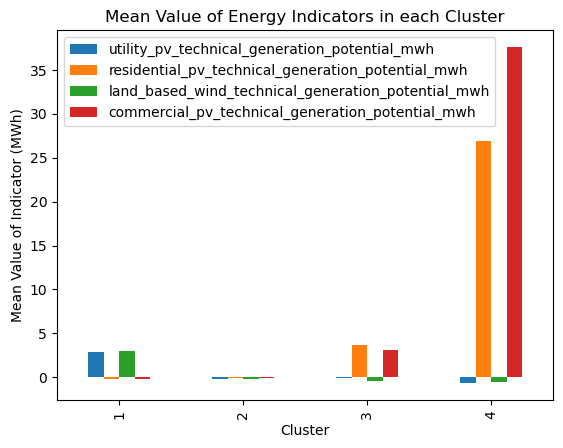

In [7]:
# Grouped bar chart
energy_means.reset_index().plot(x='Cluster', 
                                kind='bar', 
                                stacked=False, 
                                title='Mean Value of Energy Indicators in each Cluster') 
plt.ylabel("Mean Value of Indicator (MWh)")

### Step 5: Interpret Clustering Results
Interpret your plot of the resulting clusters.  How would you characterize and compare the four different clusters in terms of their profile of energy generation?

*Each of the four clusters in the figure above describe a clustering of counties based on the their values of the following indicators: `utility_pv_technical_generation_potential_mwh`, `residential_pv_technical_generation_potential_mwh`, `land_based_wind_technical_generation_potential_mwh`,`commercial_pv_technical_generation_potential_mwh`. The model appears to be clustering the values of the technical generation potential of `residential_pv_mwh` and `commerical_pv_mwh` together, and the values of the technical generation potential of `utility_pv_mwh` and `land_based_wind_mwh` together. Cluster 1 is composed of counties with a moderate potential for `utility_pv` and `land_based_wind`, and minimal to no potential for `residential_pv` and `commerical_pv`. Cluster 2 is composed of counties with minimal to no potential for any of the energy indicators. Cluster 3 is composed of counties with a moderate potential for `residential_pv` and `commerical_pv`, and minimal to no potential for `utility_pv` and `land_based_wind`. Cluster 4 is composed of counties with a high potential for `residential_pv` and `commerical_pv`, and minimal to no potential for `utility_pv` and `land_based_wind`.*

## Part II: Environmental Justice Metrics
Now it's your turn.

So far, we have clustered counties based on **energy potential**, but energy potential alone does not tell the full story of **energy equity and access**. To deepen the analysis, we need to consider environmental justice (EJ) factors that affect communities’ ability to benefit from renewable energy and the environmental burdens they already experience.

1. Explore EJSCREEN variables:  
   - The EJSCREEN subset of our dataset contains metrics on pollution burden, demographics (population size), and health risks (*lines 31-41 of the ColumnsExplained tab in the metadata sheet linked above*).
   - Identify 1-3 variables that could be important for energy equity analysis.  You could introduce them either as clustering features, as post-clustering variables to help interpret the clusters, or both. 

2. Modify the clustering approach:  
   - Add your selected EJSCREEN variables to our feature set.    
   - Re-run the hierarchical clustering analysis with the expanded dataset (if you added any as clustering features).  

3. Interpret the Results:
   Your interpretation could include considerations such as:
   - How do clusters change when EJSCREEN variables are included?  
   - Are counties with high renewable energy potential also burdened by environmental risks?  
   - What policy recommendations might emerge from these findings?  

In [8]:
# Add EJSCREEN variables to dataframe after clustering analysis has been run

# Select 5th national quintile for percent low income and
# 5th national quintile for the National Scale Air Toxics Assessment Respiratory Hazard Index columns
eeip_ej_vars = eeip_clean[["lowincome_pop_5_prop",
                           "respiratoryhazardairtoxics_5_prop"]].reset_index(drop=True)

# Combine the EJSCREEN columns with the scaled data
ej_df = pd.concat([eeip_ej_vars, scaled_df], axis=1)
ej_df.head()

# Mean values of the energy potential features for each cluster
ej_means = ej_df.groupby(['Cluster']).mean()
print(ej_means)

         lowincome_pop_5_prop  respiratoryhazardairtoxics_5_prop  \
Cluster                                                            
1                    0.195722                           0.008538   
2                    0.194740                           0.114116   
3                    0.193137                           0.203953   
4                    0.227393                           0.767395   

         utility_pv_technical_generation_potential_mwh  \
Cluster                                                  
1                                             2.831068   
2                                            -0.184742   
3                                            -0.076363   
4                                            -0.661236   

         residential_pv_technical_generation_potential_mwh  \
Cluster                                                      
1                                                -0.193351   
2                                                -0.1215

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram')

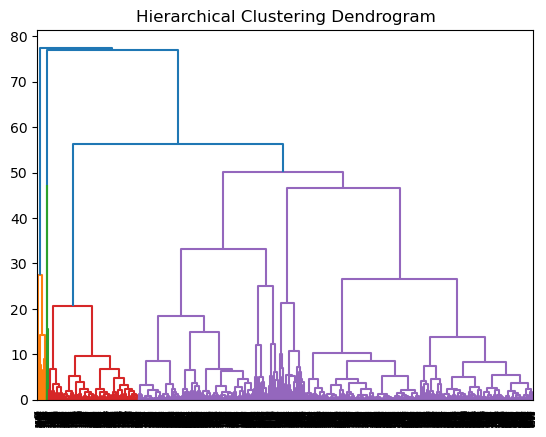

In [9]:
# Add EJSCREEN variable and re-run the hierarchical clustering analysis

# Scale data
eeip_ej_scaled = scaler.fit_transform(eeip_clean[["lowincome_pop_5_prop",
                                                  "utility_pv_technical_generation_potential_mwh",
                                                  "residential_pv_technical_generation_potential_mwh",
                                                  "land_based_wind_technical_generation_potential_mwh",
                                                  "commercial_pv_technical_generation_potential_mwh"]])

# Convert back to a DataFrame
scaled_ej_df = pd.DataFrame(eeip_ej_scaled, columns=["lowincome_pop_5_prop",
                                                     "utility_pv_technical_generation_potential_mwh",
                                                     "residential_pv_technical_generation_potential_mwh",
                                                     "land_based_wind_technical_generation_potential_mwh",
                                                     "commercial_pv_technical_generation_potential_mwh"]).reset_index(drop=True)

# Hierarchical clustering
eeip_ej_linked = linkage(scaled_ej_df, 'ward')

# Dendrogram for hierarchical clustering
dendrogram(eeip_ej_linked)
plt.title("Hierarchical Clustering Dendrogram")

         lowincome_pop_5_prop  utility_pv_technical_generation_potential_mwh  \
Cluster                                                                        
1                    0.644101                                       5.181836   
2                    0.189183                                       0.381439   
3                    1.440582                                      -0.290033   
4                   -0.343156                                      -0.055661   

         residential_pv_technical_generation_potential_mwh  \
Cluster                                                      
1                                                -0.063066   
2                                                10.858354   
3                                                -0.239731   
4                                                -0.005535   

         land_based_wind_technical_generation_potential_mwh  \
Cluster                                                       
1                   

<Axes: title={'center': 'Mean Value of Energy Indicators in each Cluster'}, xlabel='Cluster'>

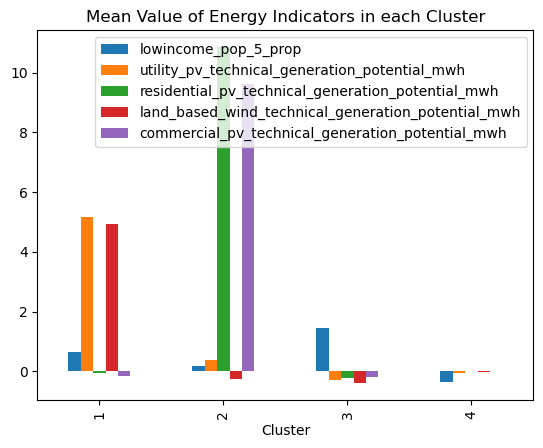

In [10]:
# Set the number of clusters based on the dendrogram
num_clusters_ej = 4

# Extract cluster assignments
cluster_labels_ej = fcluster(Z=eeip_ej_linked, t=num_clusters_ej, criterion='maxclust') 

# Add a new column `Cluster` to the cleaned datframe
scaled_ej_df['Cluster'] = cluster_labels_ej

# Mean values of the energy potential features for each cluster
ej_energy_means = scaled_ej_df.groupby(['Cluster']).mean()
print(ej_energy_means)

# Grouped bar chart
ej_energy_means.reset_index().plot(x='Cluster', 
                                   kind='bar', 
                                   stacked=False, 
                                   title='Mean Value of Energy Indicators in each Cluster') 

Which EJSCREEN variable(s) did you add to the analysis? Why did you choose these?  What is the question you are interested in? What did you learn from the analysis?

*I decided to do two different analyses for Part II so that I could look at how the EJSCREEN variable could be used to interpret clusters once the clustering analysis has been run, and look at the effect of adding additional variables to the hierarchial clustering analysis. I added the `lowincome_pop_5_prop`, `respiratoryhazardairtoxics_5_prop` EJSCREEN variables to the analysis, but only reran the hierarchial clustering analysis with the `lowincome_pop_5_prop` variable added. I wanted to see if there was a smaller or larger proportion of lower income individuals in different clusters to explain differences in energy potential indicators. Counties with a high `respiratoryhazardairtoxics_5_prop` value indicates a higher presence of air toxics that have the potential to cause adverse health effects. Since all of the clusters have an average `respiratoryhazardairtoxics_5_prop` of less than 1, which indicates air toxics are unlikely to cause adverse health effects according the EPA, this indicates that counties with a higher hazard index are spread across all of the clusters. When the `lowincome_pop_5_prop` variable was added the hierarchical clustering analysis, clusters patterns stayed similar across the energy potential indicators.*